##### Deep Reinforcement learning is used to predict buy,hold or sell share based on previous days stock prices. Stable_baselines3 has been used with  MLPpolicy

In [152]:
import random
import gym
from gym import spaces
import pandas as pd
import numpy as np
import datetime as dt
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt
from numpy import expand_dims

In [153]:
df = pd.read_csv('data.csv', header=0, parse_dates=[0])
df_cleaned = df.dropna()
df_cleaned.head(5)

,Date,Open,High,Low,Close,Shares Traded
0,2021-04-27,14493.80,14667.55,14484.85,14653.05,442211685
1,2021-04-28,14710.50,14890.25,14694.95,14864.55,453990807
2,2021-04-29,14979.00,15044.35,14814.45,14894.90,511466673
3,2021-04-30,14747.35,14855.45,14601.70,14631.10,594744498
4,2021-05-03,14481.05,14673.85,14416.25,14634.15,443410846


In [154]:
df.loc[1: 5, 'Open']

1    14710.50
2    14979.00
3    14747.35
4    14481.05
5    14687.25
Name: Open, dtype: float64

In [155]:
MAX_ACCOUNT_BALANCE = 1000000
MAX_NUM_SHARES = 1000000000
MAX_SHARE_PRICE = 19000
# MAX_SHARE_PRICE = 1
# MAX_STEPS = 2000

INITIAL_ACCOUNT_BALANCE = 100000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Discrete(3)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(5, 6), dtype=np.float16)

    def _next_observation(self):
        # Get the stock data points for the last 6 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step - 5: self.current_step, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Shares Traded'].values / MAX_NUM_SHARES,
        ])

        return frame

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        self.current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action
        amount = np.random.random()

        if action_type == 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / self.current_price)

            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * self.current_price

            self.balance -= additional_cost

            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type == 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held)

            self.balance += shares_sold * self.current_price
            self.shares_held = 0
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * self.current_price

        self.net_worth = self.balance + self.shares_held * self.current_price

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        # delay_modifier = (self.current_step / MAX_STEPS) # for long term reward
        # reward = self.balance * delay_modifier
        if action==2:
            if self.current_price>self.cost_basis:
                reward = 1
            else:
                reward = -1
        else:
            reward = 0
        
        done = False

        self.current_step += 1
        
        if self.shares_held>0:
            done = self.net_worth <= 95000
        if self.current_step > len(self.df.loc[:, 'Open'].values)-2:
            done = True

        obs = self._next_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.current_price = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            6, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [156]:
env = StockTradingEnv(df)
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward

    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:38
Episode:2 Score:34
Episode:3 Score:15
Episode:4 Score:20
Episode:5 Score:65


C:\Users\soumya\AppData\Local\Temp\ipykernel_13636\3480039452.py:56: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (


In [157]:
env = StockTradingEnv(df)
env_1 = DummyVecEnv([lambda: env])

model = DQN("MlpPolicy", env_1, verbose=1)
model.learn(total_timesteps=20000)

Using cpu device


C:\Users\soumya\AppData\Local\Temp\ipykernel_13636\3480039452.py:56: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1715     |
|    time_elapsed     | 0        |
|    total_timesteps  | 575      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.679    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1728     |
|    time_elapsed     | 0        |
|    total_timesteps  | 676      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 1818     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1282     |
----------------------------------
----------------------------------
| rollout/          

In [158]:
env_1.reset().shape

(1, 5, 6)

In [159]:
model.predict(env_1.reset())

(array([1], dtype=int64), None)

In [160]:
model.predict(env_1.step(model.predict(env_1.reset()))[0])

C:\Users\soumya\AppData\Local\Temp\ipykernel_13636\3480039452.py:56: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (


(array([1], dtype=int64), None)

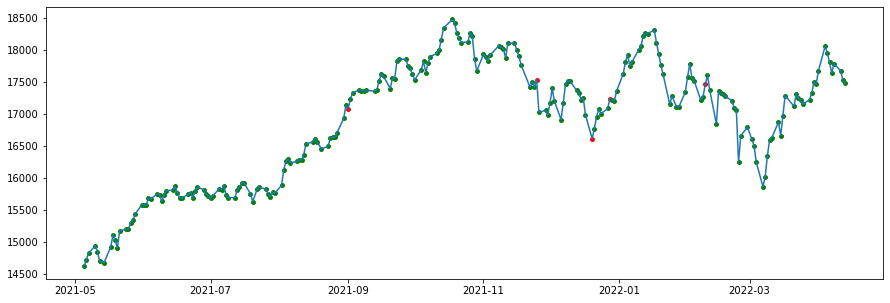

In [161]:
plt.figure(figsize=(15,5)) 
plt.plot(df.iloc[6:df.shape[0]-6,0], df.iloc[6:df.shape[0]-6,4])
for i in range (6, df.shape[0]-6):
    current_step = i
    frame = np.array([
            df.loc[current_step - 5: current_step, 'Open'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'High'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Low'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Close'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Shares Traded'].values / MAX_NUM_SHARES,
        ])
    frame = expand_dims(frame, axis=0)
    trade = model.predict(frame)[0][0]
    
    if trade == 1:
        color = 'green'
    if trade == 2:
        color = 'red'
    
    plt.scatter(df.iloc[current_step,0], df.iloc[current_step,4], c=color, s=15)   

##### Deep Reinforcement learning is used to predict buy,hold or sell share based on previous days stock prices. Rl.agents has been used with custom neural network

In [162]:
MAX_ACCOUNT_BALANCE = 1000000
MAX_NUM_SHARES = 1000000000
MAX_SHARE_PRICE = 19000
# MAX_STEPS = 2000

INITIAL_ACCOUNT_BALANCE = 100000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Discrete(3)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(30,), dtype=np.float16)

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step - 5: self.current_step, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 5: self.current_step, 'Shares Traded'].values / MAX_NUM_SHARES,
        ])

        return frame.reshape(-1)

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        self.current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action
        amount = np.random.random()

        if action_type == 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / self.current_price)

            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * self.current_price

            self.balance -= additional_cost

            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type == 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held)

            self.balance += shares_sold * self.current_price
            self.shares_held = 0
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * self.current_price

        self.net_worth = self.balance + self.shares_held * self.current_price

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        # delay_modifier = (self.current_step / MAX_STEPS) # for long term reward
        # reward = self.balance * delay_modifier
        if action==2:
            if self.current_price>self.cost_basis:
                reward = 1
            else:
                reward = -1
        else:
            reward = 0
        
        done = False

        self.current_step += 1
        
        if self.shares_held>0:
            done = self.net_worth <= 95000
        if self.current_step > len(self.df.loc[:, 'Open'].values)-2:
            done = True

        obs = self._next_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.current_price = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            6, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [163]:
env = StockTradingEnv(df)
states = env.observation_space.shape
actions = env.action_space.n
states,actions

((30,), 3)

In [164]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=(1,states[0])))
    model.add(Dense(24, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear'))
    return model

model = build_model(states, actions)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1, 24)             744       
                                                                 
 dense_4 (Dense)             (None, 1, 24)             600       
                                                                 
 flatten_1 (Flatten)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 75        
                                                                 
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.output.shape

TensorShape([None, 3])

In [166]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=10000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [167]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=10000, visualize=False, verbose=1)

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 10000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 16:31 - reward: 0.0000e+00

c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\soumya\AppData\Local\Temp\ipykernel_13636\1620360116.py:55: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (
c:\ProgramData\Anaconda3\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 106s 11ms/step - reward: 0.5784
done, took 105.847 seconds


In [168]:
results = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(results.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 6.000, steps: 6
Episode 2: reward: 134.000, steps: 134
Episode 3: reward: 39.000, steps: 39
Episode 4: reward: 212.000, steps: 212
Episode 5: reward: 21.000, steps: 21
Episode 6: reward: 40.000, steps: 40
Episode 7: reward: 56.000, steps: 56
Episode 8: reward: 79.000, steps: 79
Episode 9: reward: 112.000, steps: 112
Episode 10: reward: 200.000, steps: 200
89.9


In [169]:
env.observation_space.sample()

array([0.2406 , 0.176  , 0.3596 , 0.7563 , 0.9536 , 0.847  , 0.262  ,
       0.2362 , 0.5786 , 0.03018, 0.9165 , 0.998  , 0.4976 , 0.1165 ,
       0.8726 , 0.1758 , 0.3452 , 0.3223 , 0.2279 , 0.7563 , 0.7476 ,
       0.1586 , 0.8677 , 0.731  , 0.12476, 0.6445 , 0.202  , 0.01718,
       0.5215 , 0.2456 ], dtype=float16)

In [170]:
dqn.forward(env.observation_space.sample())

2

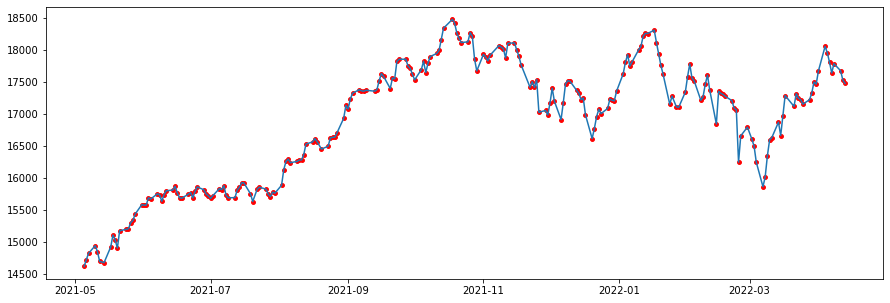

In [171]:
plt.figure(figsize=(15,5)) 
plt.plot(df.iloc[6:df.shape[0]-6,0], df.iloc[6:df.shape[0]-6,4])
for i in range (6, df.shape[0]-6):
    current_step = i
    frame = np.array([
            df.loc[current_step - 5: current_step, 'Open'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'High'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Low'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Close'].values / MAX_SHARE_PRICE,
            df.loc[current_step - 5: current_step, 'Shares Traded'].values / MAX_NUM_SHARES,
        ])
    frame = frame.reshape(-1)
    trade = dqn.forward(frame)
    
    if trade == 1:
        color = 'green'
    if trade == 2:
        color = 'red'
    
    plt.scatter(df.iloc[current_step,0], df.iloc[current_step,4], c=color, s=15)   